
# 📘 Documentación del Código - Predicción de Producción Agrícola con LSTM

Este código implementa una red neuronal LSTM multivariada para predecir la producción agrícola mensual a nivel de cantón, usando datos históricos y climáticos.


### 1. 📦 Importación de librerías

Se importan librerías necesarias para preprocesamiento, visualización, modelado y evaluación del modelo.


In [72]:
# 1. Importación de librerías
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings('ignore')
import os
from src.utils.metrics import obtener_ruta_app

In [93]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


### 2. 📂 Carga de datos

In [94]:
def cargar_datos(archivo_csv):
    """
    Carga los datos manteniendo la estructura multivariada
    """
    df = pd.read_csv(archivo_csv, parse_dates=['fecha'])
    df = df.sort_values(['fecha', 'canton_id'])  # Ordenar por fecha y cantón
    print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
    print(f"Rango de fechas: {df['fecha'].min()} a {df['fecha'].max()}")
    print(f"Cantones únicos: {df['canton_id'].nunique()}")
    return df

In [95]:
base_path = obtener_ruta_app("TemplateAgroIA")
file_path = os.path.join(base_path, "data", "processed", "rnn", "rnn_produccion.csv")
df = cargar_datos(file_path)

Datos cargados: 630 filas, 12 columnas
Rango de fechas: 2015-01-01 00:00:00 a 2025-06-01 00:00:00
Cantones únicos: 5


### 3. 🛠 Preprocesamiento de datos

- **Codificación one-hot** del `canton_id`.
- Separación de variables independientes (`X`) y variable objetivo (`y`).
- Se muestra información general del dataset.


In [96]:
def preparar_datos_multivariado(df):
    """
    Prepara los datos para modelo multivariado con one-hot encoding
    """
    # One-hot encoding para cantón
    df_encoded = pd.get_dummies(df, columns=['canton_id'], prefix='canton')

    # Separar features y target
    canton_cols = [col for col in df_encoded.columns if col.startswith('canton_')]

    # Definir features (excluir fecha y produccion)
    feature_cols = [col for col in df_encoded.columns
                   if col not in ['fecha', 'produccion']]

    # Crear dataset con todas las features
    X = df_encoded[feature_cols].values
    y = df_encoded['produccion'].values.reshape(-1, 1)  # Solo producción

    print(f"Shape de X (features): {X.shape}")
    print(f"Shape de y (target): {y.shape}")
    print(f"Features incluidas: {feature_cols}")

    return X, y, feature_cols, df_encoded

In [97]:
X, y, feature_cols, df_encoded = preparar_datos_multivariado(df)

Shape de X (features): (630, 14)
Shape de y (target): (630, 1)
Features incluidas: ['area', 'PRECTOTCORR_SUM', 'RH2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'WS2M', 'canton_0', 'canton_1', 'canton_2', 'canton_3', 'canton_4']


### 4. 🔀 División entrenamiento y prueba

Se separan los últimos 12 meses como conjunto de prueba para respetar la estructura temporal de los datos.


In [98]:
def dividir_train_test_multivariado_v2(X, y, df_encoded, meses_test=12):
    """
    Divide datos multivariados manteniendo estructura temporal
    """
    fechas_unicas = sorted(df_encoded['fecha'].unique())
    split_date = fechas_unicas[-meses_test]

    # Obtener índices de división
    train_idx = df_encoded['fecha'] < split_date
    test_idx = df_encoded['fecha'] >= split_date

    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]

    print(f"Datos de entrenamiento: {X_train.shape}, {y_train.shape}")
    print(f"Datos de prueba: {X_test.shape}, {y_test.shape}")

    return X_train, X_test, y_train, y_test, split_date

In [99]:
X_train, X_test, y_train, y_test, split_date = dividir_train_test_multivariado_v2(
        X, y, df_encoded, meses_test=12)

Datos de entrenamiento: (570, 14), (570, 1)
Datos de prueba: (60, 14), (60, 1)


### 5. 📉 Escalado de datos

Se normalizan las variables independientes y la variable objetivo usando `MinMaxScaler` para mejorar el entrenamiento del modelo.


In [100]:
def escalar_datos_multivariado_v2(X_train, X_test, y_train, y_test):
    """
    Escala features y target por separado
    """
    # Escalar features
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Escalar target
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y

In [101]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y = escalar_datos_multivariado_v2(
        X_train, X_test, y_train, y_test)

### 6. ⏱ Creación de secuencias temporales

Se construyen secuencias de 12 pasos (meses) para alimentar la red LSTM. Esto permite capturar patrones temporales a largo plazo.


In [102]:
def crear_secuencias_multivariadas(X_scaled, y_scaled, length=12):
    """
    Crea secuencias temporales para modelo multivariado
    """
    X_sequences = []
    y_sequences = []

    for i in range(length, len(X_scaled)):
        X_sequences.append(X_scaled[i-length:i])
        y_sequences.append(y_scaled[i])

    return np.array(X_sequences), np.array(y_sequences)

In [103]:
length = 12
X_train_seq, y_train_seq = crear_secuencias_multivariadas(X_train_scaled, y_train_scaled, length)
X_test_seq, y_test_seq = crear_secuencias_multivariadas(X_test_scaled, y_test_scaled, length)

print(f"Shape de secuencias de entrenamiento: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"Shape de secuencias de prueba: {X_test_seq.shape}, {y_test_seq.shape}")

Shape de secuencias de entrenamiento: (558, 12, 14), (558, 1)
Shape de secuencias de prueba: (48, 12, 14), (48, 1)


### 7. 🧠 Definición del modelo LSTM multivariado

Se construye un modelo `Sequential` con capas LSTM bidireccionales, regularización, `Dropout`, y capas densas al final. Se compila con el optimizador `Adam`.


In [104]:
def crear_modelo_lstm_multivariado(input_shape, units=128, dropout_rate=0.2):
    """
    Crea modelo LSTM multivariado que predice solo producción
    """
    model = Sequential([
        # Primera capa LSTM bidireccional
        Bidirectional(LSTM(units, return_sequences=True, input_shape=input_shape)),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Segunda capa LSTM bidireccional
        Bidirectional(LSTM(units//2, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Tercera capa LSTM
        LSTM(units//2, return_sequences=False),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Capas densas
        Dense(50, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(dropout_rate),
        Dense(25, activation='relu'),
        Dense(1)  # Solo una salida: producción
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [105]:
input_shape = (length, X_train_seq.shape[2])  # (timesteps, features)
model = crear_modelo_lstm_multivariado(input_shape)

print(f"Input shape: {input_shape}")
model.summary()

Input shape: (12, 14)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_54                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_55                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 8. 🚂 Entrenamiento del modelo

Se entrena el modelo con `EarlyStopping` para evitar sobreajuste, monitoreando la pérdida de validación.



In [106]:
def entrenar_modelo_multivariado(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq,
                                epochs=150, batch_size=32, patience=20):
    """
    Entrena el modelo multivariado
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=epochs,
        batch_size=batch_size,
        #callbacks=[early_stopping],
        verbose=1
    )

    return history

In [107]:
y = np.log1p(df_encoded['produccion'].values.reshape(-1, 1))


In [108]:
history = entrenar_modelo_multivariado(
        model, X_train_seq, y_train_seq, X_test_seq, y_test_seq
    )

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 5.2508 - mae: 0.7801 - val_loss: 4.0988 - val_mae: 0.2074
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.2332 - mae: 0.4354 - val_loss: 3.8324 - val_mae: 0.2037
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8186 - mae: 0.3084 - val_loss: 3.5411 - val_mae: 0.2052
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5047 - mae: 0.2833 - val_loss: 3.2536 - val_mae: 0.2080
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.1808 - mae: 0.2564 - val_loss: 2.9567 - val_mae: 0.2090
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8676 - mae: 0.2280 - val_loss: 2.6634 - val_mae: 0.2097
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5769 - mae: 0.2271 - val_loss: 2.3753 - val_mae: 0.2088
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.2856 - mae: 0.2122 - val_loss: 2.1043 - val_mae: 0.2094
Epoch 9/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - lo

In [109]:
y_pred_log = model.predict(X_test_seq)
y_pred = np.expm1(y_pred_log)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


### 9. 📊 Evaluación del modelo

Se hacen predicciones sobre el conjunto de prueba, se desescalan los resultados, y se calculan las métricas:
- MAE
- MSE
- R²



In [110]:
def evaluar_modelo_multivariado_v2(model, X_test_seq, y_test_seq, scaler_y):
    """
    Evalúa el modelo multivariado
    """
    # Predicciones
    predictions_scaled = model.predict(X_test_seq)

    # Desescalar
    predictions = scaler_y.inverse_transform(predictions_scaled)
    real_values = scaler_y.inverse_transform(y_test_seq)

    # Métricas
    mae = mean_absolute_error(real_values, predictions)
    mse = mean_squared_error(real_values, predictions)
    r2 = r2_score(real_values, predictions)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")

    return predictions, real_values

In [111]:
predictions, real_values = evaluar_modelo_multivariado_v2(
        model, X_test_seq, y_test_seq, scaler_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 29.4076
MSE: 1310.3537
R²: 0.0632


### 10. 🔮 Predicción futura (Forecast)

Se utiliza la última secuencia disponible para predecir los siguientes 6 meses. Se asume que las variables independientes no cambian (simplificación).


In [112]:
def forecast_futuro_multivariado(model, X_scaled, scaler_X, scaler_y, length=12, pasos_futuros=6):
    """
    Realiza predicciones futuras con modelo multivariado
    NOTA: Requiere valores futuros de las features (área, clima, cantón)
    """
    # Obtener la última secuencia
    last_sequence = X_scaled[-length:]

    forecast = []
    current_sequence = last_sequence.copy()

    for _ in range(pasos_futuros):
        # Predecir siguiente valor
        next_pred = model.predict(current_sequence.reshape(1, length, -1), verbose=0)
        forecast.append(next_pred[0, 0])

        # Para forecast multivariado, necesitarías actualizar current_sequence
        # con nuevos valores de features. Aquí simplificamos manteniendo
        # las features constantes y solo actualizando la secuencia temporal

        # Actualizar secuencia (esto es una simplificación)
        current_sequence = np.roll(current_sequence, -1, axis=0)
        # current_sequence[-1] = ... # Aquí necesitarías los valores futuros de features

    # Desescalar predicciones
    forecast = np.array(forecast).reshape(-1, 1)
    forecast_unscaled = scaler_y.inverse_transform(forecast)

    return forecast_unscaled.flatten()

In [23]:
model_path = os.path.join(base_path, "models", "modelo_LSTM_multivariado.keras")
model.save(model_path)
print("Modelo guardado con éxito.")

Modelo guardado con éxito.


### 11. 💾 Guardado del modelo y scalers

Se guarda el modelo entrenado (`.keras`) y los objetos `scaler_X`, `scaler_y`, y las columnas de features para uso futuro.



In [54]:
def guardar_scalers_y_features(scaler_X, scaler_y, feature_cols, base_path):
    """
    Guarda los scalers y columnas de features para uso posterior
    """
    # Crear directorio models si no existe
    models_dir = os.path.join(base_path, "models")
    os.makedirs(models_dir, exist_ok=True)

    # Guardar scaler de features (X)
    scaler_X_path = os.path.join(models_dir, "scaler_X_multivariado.pkl")
    with open(scaler_X_path, 'wb') as f:
        pickle.dump(scaler_X, f)

    # Guardar scaler de target (y)
    scaler_y_path = os.path.join(models_dir, "scaler_y_multivariado.pkl")
    with open(scaler_y_path, 'wb') as f:
        pickle.dump(scaler_y, f)

    # Guardar columnas de features
    features_path = os.path.join(models_dir, "feature_columns_multivariado.pkl")
    with open(features_path, 'wb') as f:
        pickle.dump(feature_cols, f)

    print("✅ Scalers y features guardados correctamente.")
    print(f"   - Scaler X: {scaler_X_path}")
    print(f"   - Scaler y: {scaler_y_path}")
    print(f"   - Features: {features_path}")


In [55]:
guardar_scalers_y_features(scaler_X, scaler_y, feature_cols, base_path)

✅ Scalers y features guardados correctamente.
   - Scaler X: C:\TemplateAgroIA\models\scaler_X_multivariado.pkl
   - Scaler y: C:\TemplateAgroIA\models\scaler_y_multivariado.pkl
   - Features: C:\TemplateAgroIA\models\feature_columns_multivariado.pkl


### 12. 📈 Visualización del entrenamiento

Se grafican las curvas de pérdida (MSE) y MAE tanto para entrenamiento como validación, para entender el comportamiento del modelo durante las épocas.

In [56]:
def visualizar_entrenamiento(history):
    """
    Visualiza las curvas de entrenamiento y validación
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico de pérdida
    ax1.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validación', linewidth=2)
    ax1.set_title('Pérdida del Modelo', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida (MSE)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico de MAE
    ax2.plot(history.history['mae'], label='Entrenamiento', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validación', linewidth=2)
    ax2.set_title('Error Absoluto Medio', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Imprimir estadísticas finales
    print("\n=== ESTADÍSTICAS FINALES ===")
    print(f"Pérdida final (entrenamiento): {history.history['loss'][-1]:.4f}")
    print(f"Pérdida final (validación): {history.history['val_loss'][-1]:.4f}")
    print(f"MAE final (entrenamiento): {history.history['mae'][-1]:.4f}")
    print(f"MAE final (validación): {history.history['val_mae'][-1]:.4f}")
    print(f"Épocas entrenadas: {len(history.history['loss'])}")


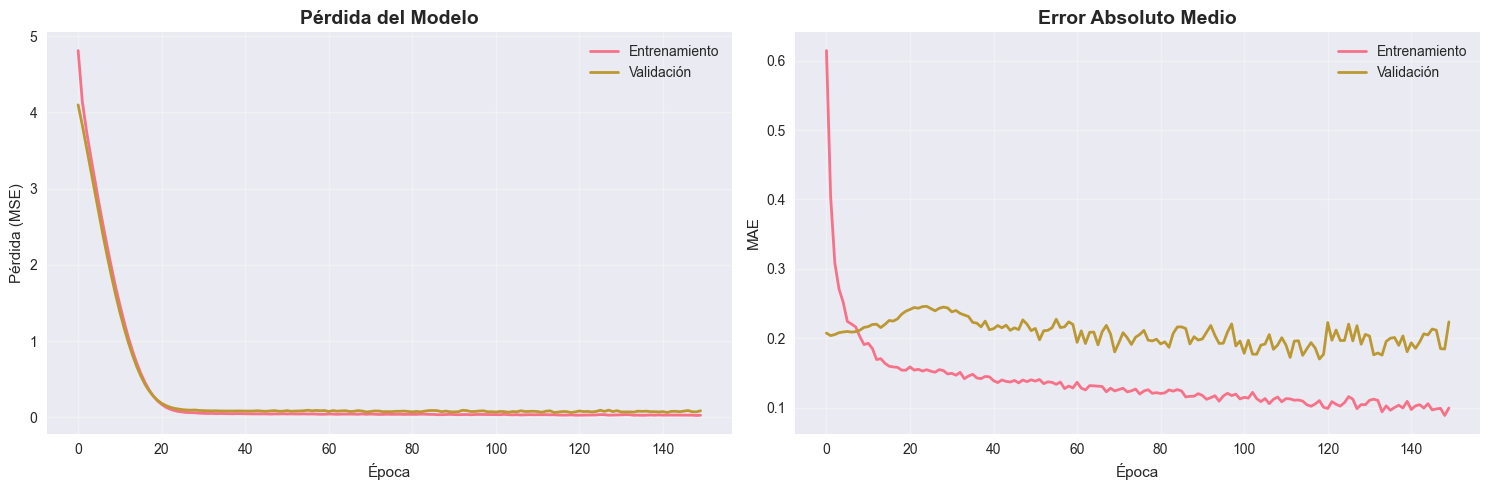


=== ESTADÍSTICAS FINALES ===
Pérdida final (entrenamiento): 0.0292
Pérdida final (validación): 0.0874
MAE final (entrenamiento): 0.0994
MAE final (validación): 0.2235
Épocas entrenadas: 150


In [113]:
visualizar_entrenamiento(history)

### 13. 📦 Carga del modelo para pruebas

Se carga el modelo y los escaladores desde disco para realizar pruebas con nuevos datos.


In [58]:
model_path = os.path.join(base_path, "models", "modelo_LSTM_multivariado.keras")
scaler_y_path = os.path.join(base_path, "models", "scaler_y_multivariado.pkl")
scaler_X_path = os.path.join(base_path, "models", "scaler_X_multivariado.pkl")
features_path = os.path.join(base_path, "models", "feature_columns_multivariado.pkl")

modelo_cargado = tf.keras.models.load_model(model_path)
with open(scaler_y_path, 'rb') as f:
    scaler_y_cargado = pickle.load(f)
with open(scaler_X_path, 'rb') as f:
    scaler_X_cargado = pickle.load(f)
with open(features_path, 'rb') as f:
    columnas_features = pickle.load(f)

print("✅ Modelo y scalers cargados")

✅ Modelo y scalers cargados


### Cargar datos de prueba

In [59]:
test_file_path = os.path.join(base_path, "data", "raw", "df_prueba_produccion.csv")
df_test = pd.read_csv(test_file_path, parse_dates=['fecha'])

# Tomar últimos 12 meses de un cantón
canton_id = df_test['canton_id'].iloc[0]
df_test = df_test[df_test['canton_id'] == canton_id].tail(12)

print(f"Usando {len(df_test)} registros del cantón {canton_id}")

Usando 12 registros del cantón 205


### Preparar datos

In [60]:
df_encoded = pd.get_dummies(df_test, columns=['canton_id'], prefix='canton')
for col in columnas_features:
    if col not in df_encoded.columns:
        df_encoded[col] = 0
df_encoded = df_encoded[columnas_features]

X_scaled = scaler_X_cargado.transform(df_encoded.values)

### Hacer predicción

In [61]:
meses_a_predecir = 6
predicciones = []
current_seq = X_scaled.copy()

for i in range(meses_a_predecir):
    pred = modelo_cargado.predict(current_seq.reshape(1, 12, -1), verbose=0)
    predicciones.append(pred[0, 0])
    # Rotar secuencia para siguiente predicción
    current_seq = np.roll(current_seq, -1, axis=0)

### Desescalar predicciones

In [62]:
predicciones_reales = scaler_y_cargado.inverse_transform(np.array(predicciones).reshape(-1, 1)).flatten()

print(f"Predicciones para los próximos {meses_a_predecir} meses:")
for i, pred in enumerate(predicciones_reales, 1):
    print(f"Mes {i}: {pred:.2f} unidades")

Predicciones para los próximos 6 meses:
Mes 1: 12.79 unidades
Mes 2: 12.28 unidades
Mes 3: 12.84 unidades
Mes 4: 13.35 unidades
Mes 5: 13.33 unidades
Mes 6: 13.94 unidades


### Gráfico con múltiples predicciones

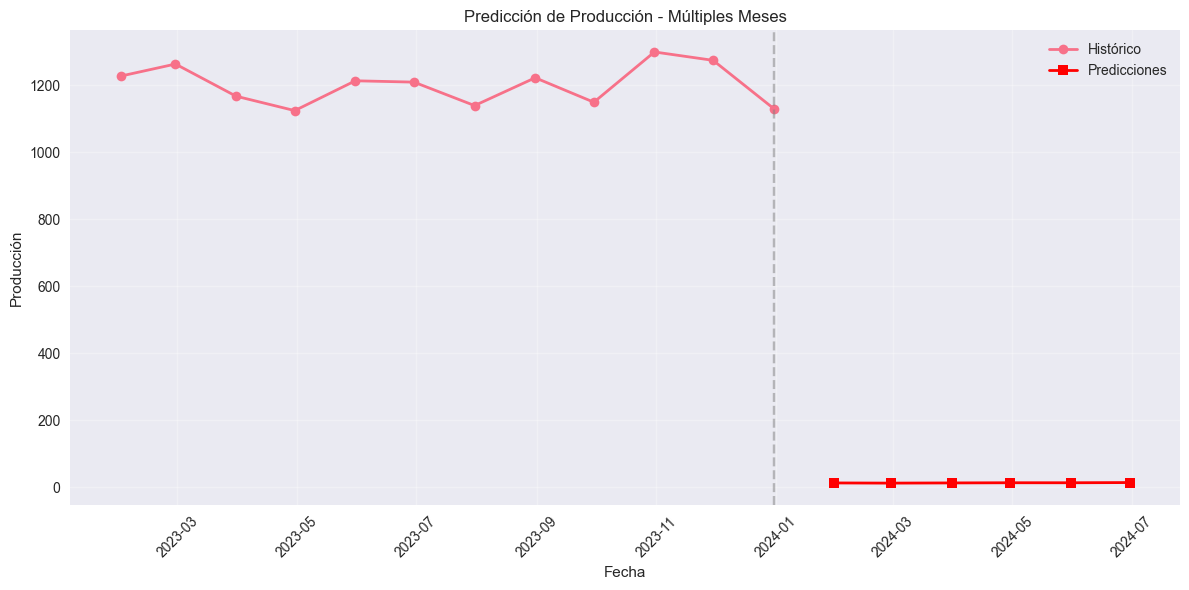

Producción promedio histórica: 1201.33
Predicción promedio: 13.09
Diferencia promedio: -1188.24


In [63]:
fechas_futuras = pd.date_range(start=df_test['fecha'].max() + pd.DateOffset(months=1),
                              periods=meses_a_predecir, freq='ME')

plt.figure(figsize=(12, 6))
plt.plot(df_test['fecha'], df_test['produccion'], 'o-', label='Histórico', linewidth=2)
plt.plot(fechas_futuras, predicciones_reales, 's-', color='red', label='Predicciones', linewidth=2)
plt.axvline(x=df_test['fecha'].max(), color='gray', linestyle='--', alpha=0.5)
plt.title('Predicción de Producción - Múltiples Meses')
plt.xlabel('Fecha')
plt.ylabel('Producción')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Producción promedio histórica: {df_test['produccion'].mean():.2f}")
print(f"Predicción promedio: {np.mean(predicciones_reales):.2f}")
print(f"Diferencia promedio: {np.mean(predicciones_reales) - df_test['produccion'].mean():.2f}")

In [64]:
pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()


NameError: name 'pred_scaled' is not defined